Pandas and excel imports

In [914]:
import pandas as pd
from openpyxl import Workbook # Creates excel file
from openpyxl.worksheet.table import Table, TableStyleInfo # For creating and styling tables
from openpyxl.utils.dataframe import dataframe_to_rows # For importing pandas DataSet to excel
from openpyxl.utils import get_column_letter
from openpyxl.drawing.image import Image
from openpyxl.formatting.rule import ColorScaleRule

Graph imports

In [915]:
import seaborn as sns
import matplotlib.pyplot as plt

Loading file

In [916]:
file_data = pd.read_csv("./data/sales_data_sample.csv", encoding="Latin-1")

Total sales by year

In [917]:
total_sales_year = file_data.groupby("YEAR_ID")["SALES"].sum().reset_index().rename(columns={"YEAR_ID": "Year", "SALES": "Total revenue"})

Ranking customers

In [918]:
best_customers = file_data.groupby("CUSTOMERNAME")["SALES"].sum().reset_index().rename(columns={ "CUSTOMERNAME": "Customer", "SALES": "Spent" })

best_customers["Customer rank"] = best_customers["Spent"].rank(ascending=False, method="dense")

best_customers = best_customers.sort_values(["Customer rank"]).head(10).reset_index()

Filtering shipped orders

In [919]:
shipped_orders = file_data[file_data["STATUS"] == "Shipped"].reset_index()

Sales by product line

In [920]:
sales_by_line = file_data.groupby("ORDERLINENUMBER")["SALES"].sum().reset_index().rename(columns={ "ORDERLINENUMBER": "Product line", "SALES": "Sales" })

Helper excel function

In [921]:
def write_df_to_sheet(dataframe, sheet, t_name, to_format=[], currency_columns={}):
    if "index" in dataframe.columns:
        dataframe.drop("index", axis=1, inplace=True)
    
    rows = dataframe_to_rows(dataframe, index=False)

    for r_indx, row in enumerate(rows, 1):
        for c_indx, value in enumerate(row, 1):
            new_cell = sheet.cell(row=r_indx, column=c_indx, value=value)
            column_letter = get_column_letter(c_indx)

            if isinstance(value, str) and sheet.column_dimensions[column_letter].width < len(value) + 2:
                sheet.column_dimensions[column_letter].width = len(value) + 2

            if dataframe.columns[c_indx-1] in currency_columns:
                new_cell.number_format = '$#,###,##0.00'
                sheet.column_dimensions[column_letter].width = 13
    
    t_style = TableStyleInfo(name="TableStyleMedium9", showRowStripes=True)
    t = Table(displayName=t_name, ref="A1:" + get_column_letter(sheet.max_column) + str(sheet.max_row))

    t.tableStyleInfo = t_style

    sheet.add_table(t)

    if to_format is not None:
        for column in to_format:
            column_letter = get_column_letter(dataframe.columns.get_loc(column) + 1)
            format_range = f"{column_letter}1:{column_letter}{sheet.max_row}"
            format_rule = ColorScaleRule(start_type="min", start_color="F8696B", mid_type="percentile", mid_color="FFEB84", mid_value=50, end_type="max", end_color="63BE7B")
            sheet.conditional_formatting.add(format_range, format_rule)


Creating excel data

In [922]:
result = Workbook()

result.active.title = "Sales per year"
customer_sheet = result.create_sheet("Best customers")
line_sheet = result.create_sheet("Sales by product line")
shipped_sheet = result.create_sheet("Shipped orders")

write_df_to_sheet(total_sales_year, result.active, "sales_year", ["Total revenue"], {"Total revenue"})
write_df_to_sheet(best_customers, customer_sheet, "top_customers", ["Spent"], {"Spent"})
write_df_to_sheet(sales_by_line, line_sheet, "sales_line", ["Sales"], {"Sales"})
write_df_to_sheet(shipped_orders, shipped_sheet, "shipper_orders", ["SALES"], {"SALES", "PRICEEACH"})

Generating sales trend data

In [923]:
MONTH_ARRAY = { 1: "JAN", 2: "FEB", 3: "MAR", 4: "APR", 5: "MAY", 6: "JUN", 7: "JUL", 8: "AUG", 9: "SEP", 10: "OCT", 11: "NOV", 12: "DEC" }

sales_per_month = file_data.groupby("MONTH_ID")["SALES"].sum().reset_index().rename(columns={"MONTH_ID": "MONTH"})

sales_per_month["MONTH"] = sales_per_month["MONTH"].map(MONTH_ARRAY)

Graph generation

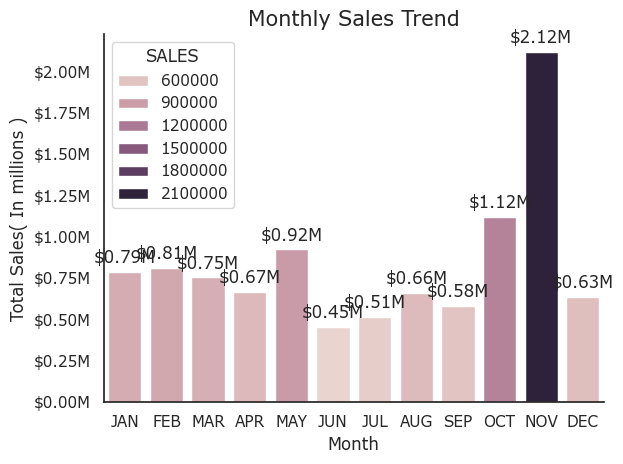

In [924]:
sns.set(font="Verdana", style="white")

plot = sns.barplot(x="MONTH", y="SALES", data=sales_per_month, hue="SALES")

plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x/1e6:.2f}M"))

plt.title("Monthly Sales Trend", fontsize=15)
plt.xlabel("Month")
plt.ylabel("Total Sales( In millions )")

for p in plot.patches:
    if p.get_height() == 0: continue
    plot.annotate(f"${p.get_height()/1e6:.2f}M", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()

sns.despine()

plt.savefig("./output/sales_trend.png")

Adding graph to excel

In [925]:
graph_sheet = result.create_sheet("Monthly Sales Trend")

graph_img = Image("./output/sales_trend.png")

graph_sheet.add_image(graph_img, "A1")

result.save("./output/sales_data_report.xlsx")